Overfitting & Regularization

1. Train and test a Lasso regression
2. Get the values at which there is no overfitting
3. Visualize coefficients for relevant features



In [17]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
np.seterr(divide='ignore', invalid='ignore')

# Hide deprecated warnings
import warnings
warnings.filterwarnings('ignore')

## Load the clean feature vector and build train/test sets

In [18]:
# Load data from the folder where I uploaded the csv file
data = pd.read_csv("/Users/gjg/code/giovjg/datascience/house_price_project/datasets/feature_vector.csv")


In [19]:
data.head(10)

,Id,SalePrice,set,log_SalePrice,st_LotFrontage,st_LotArea,st_MasVnrArea,st_BsmtFinSF1,st_BsmtUnfSF,st_TotalBsmtSF,...,st_EnclosedPorch_0,st_EnclosedPorch_1,st_3SsnPorch_0,st_3SsnPorch_1,st_ScreenPorch_0,st_ScreenPorch_1,st_PoolArea_0,st_PoolArea_1,st_MiscVal_0,st_MiscVal_1
0,1,208500.0,train,12.247694,-2.020675e-01,-0.217879,0.525202,0.581145,-0.934165,-0.443078,...,1,0,1,0,1,0,1,0,1,0
1,2,181500.0,train,12.109011,5.018705e-01,-0.072044,-0.572250,1.178255,-0.629284,0.477463,...,1,0,1,0,1,0,1,0,1,0
2,3,223500.0,train,12.317167,-6.127993e-02,0.137197,0.334828,0.098189,-0.287999,-0.297968,...,1,0,1,0,1,0,1,0,1,0
3,4,140000.0,train,11.849398,-4.367135e-01,-0.078385,-0.572250,-0.494529,-0.046824,-0.669812,...,1,0,1,0,1,0,1,0,1,0
4,5,250000.0,train,12.429216,6.895873e-01,0.518903,1.387486,0.469187,-0.160586,0.212184,...,1,0,1,0,1,0,1,0,1,0
5,6,143000.0,train,11.870600,7.365165e-01,0.500515,-0.572250,0.638222,-1.129835,-0.579118,...,1,0,0,1,1,0,1,0,1,0
6,7,307000.0,train,12.634603,2.672245e-01,-0.010667,0.469209,2.036599,-0.554201,1.438817,...,1,0,1,0,1,0,1,0,1,0
7,8,200000.0,train,12.206073,1.369237e-14,0.027123,0.771569,0.917019,-0.783999,0.126025,...,1,0,1,0,1,0,1,0,1,0
8,9,129900.0,train,11.774520,-8.590763e-01,-0.513352,-0.572250,-0.968705,0.890571,-0.225413,...,1,0,1,0,1,0,1,0,1,0
9,10,118000.0,train,11.678440,-9.060055e-01,-0.348496,-0.572250,0.899457,-0.956917,-0.136987,...,1,0,1,0,1,0,1,0,1,0


In [20]:
# Extract only data for train/test the model that contain the target values
condition = ~data['log_SalePrice'].isnull()
relevant_data = data[condition]

# Drop the columns that are not relevant
#we remove id variable because we integrated the id in the index
non_relevant_columns = ['SalePrice', 'set']
relevant_data = relevant_data.drop(non_relevant_columns, axis=1)

In [21]:
relevant_data = relevant_data.set_index('Id')

In [22]:
# Check the dimensions
relevant_data.shape

(1460, 390)

In [23]:
#check if id in the index
relevant_data.head()

,log_SalePrice,st_LotFrontage,st_LotArea,st_MasVnrArea,st_BsmtFinSF1,st_BsmtUnfSF,st_TotalBsmtSF,st_1stFlrSF,st_2ndFlrSF,st_GrLivArea,...,st_EnclosedPorch_0,st_EnclosedPorch_1,st_3SsnPorch_0,st_3SsnPorch_1,st_ScreenPorch_0,st_ScreenPorch_1,st_PoolArea_0,st_PoolArea_1,st_MiscVal_0,st_MiscVal_1
Id,,,,,,,,,,,,,,,,,,,,,
1,12.247694,-0.202068,-0.217879,0.525202,0.581145,-0.934165,-0.443078,-0.773861,1.207379,0.413547,...,1,0,1,0,1,0,1,0,1,0
2,12.109011,0.501870,-0.072044,-0.572250,1.178255,-0.629284,0.477463,0.261075,-0.785025,-0.471891,...,1,0,1,0,1,0,1,0,1,0
3,12.317167,-0.061280,0.137197,0.334828,0.098189,-0.287999,-0.297968,-0.610718,1.235375,0.563755,...,1,0,1,0,1,0,1,0,1,0
4,11.849398,-0.436714,-0.078385,-0.572250,-0.494529,-0.046824,-0.669812,-0.506205,0.978742,0.427382,...,1,0,1,0,1,0,1,0,1,0
5,12.429216,0.689587,0.518903,1.387486,0.469187,-0.160586,0.212184,-0.037170,1.671651,1.378042,...,1,0,1,0,1,0,1,0,1,0


In [24]:
# Get the columns that have any missing value
s_missing_values = relevant_data.isnull().sum()
s_missing_values[s_missing_values > 0]

Series([], dtype: int64)

## Train and test Lasso Regression for different levels of regularization

In [25]:
## Split X and y for the cross-validation model training: 
#you need to remove the target variable , in this case 'log_SalePrice', axis=1 means column
X = relevant_data.drop(['log_SalePrice'], axis=1)
y = relevant_data[['log_SalePrice']]

# Split the relevant data between train and test datasets: X (data w/o sale price) is the dataset, 
#y is the target variable data, test_size=0.2 means 20% it could be 30%
# # where does the split occur?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
#check if id in the index
X_train.head()

,st_LotFrontage,st_LotArea,st_MasVnrArea,st_BsmtFinSF1,st_BsmtUnfSF,st_TotalBsmtSF,st_1stFlrSF,st_2ndFlrSF,st_GrLivArea,st_TotRmsAbvGrd,...,st_EnclosedPorch_0,st_EnclosedPorch_1,st_3SsnPorch_0,st_3SsnPorch_1,st_ScreenPorch_0,st_ScreenPorch_1,st_PoolArea_0,st_PoolArea_1,st_MiscVal_0,st_MiscVal_1
Id,,,,,,,,,,,,,,,,,,,,,
255,0.032578,-0.224219,-0.57225,1.055320,-0.383559,0.595365,0.393628,-0.785025,-0.369117,-0.925062,...,1,0,1,0,1,0,1,0,1,0
1067,-0.483643,-0.295615,-0.57225,-0.968705,0.542461,-0.572316,-0.919160,1.016070,0.138824,0.349546,...,1,0,1,0,1,0,1,0,1,0
639,-0.108209,-0.176411,-0.57225,-0.968705,0.535635,-0.579118,-0.926807,-0.785025,-1.392904,-1.562366,...,1,0,1,0,1,0,1,0,1,0
800,-0.436714,-0.376395,0.83876,0.280395,-0.906862,-0.726496,-0.455223,1.051066,0.528180,0.349546,...,1,0,1,0,1,0,1,0,1,0
381,-0.906006,-0.655383,-0.57225,-0.490139,0.562938,-0.057630,-0.340514,0.766437,0.375995,-0.287758,...,1,0,1,0,1,0,1,0,1,0


In [27]:
#check if id in the index
X_test.head()

,st_LotFrontage,st_LotArea,st_MasVnrArea,st_BsmtFinSF1,st_BsmtUnfSF,st_TotalBsmtSF,st_1stFlrSF,st_2ndFlrSF,st_GrLivArea,st_TotRmsAbvGrd,...,st_EnclosedPorch_0,st_EnclosedPorch_1,st_3SsnPorch_0,st_3SsnPorch_1,st_ScreenPorch_0,st_ScreenPorch_1,st_PoolArea_0,st_PoolArea_1,st_MiscVal_0,st_MiscVal_1
Id,,,,,,,,,,,,,,,,,,,,,
893,0.032578,-0.222444,-0.572250,0.486749,-0.374458,0.017193,-0.233451,-0.785025,-0.855317,-0.287758,...,1,0,1,0,1,0,1,0,1,0
1106,1.346596,0.264770,1.454677,1.296799,-0.294825,0.933199,0.867761,1.832629,2.216046,1.624153,...,1,0,1,0,1,0,1,0,1,0
414,-0.624430,-0.153204,-0.572250,-0.968705,1.017984,-0.098442,-0.335415,-0.785025,-0.934374,-0.925062,...,1,0,1,0,1,0,1,0,1,0
523,-0.906006,-0.655383,-0.572250,-0.092798,0.101066,-0.107511,-0.396594,0.754772,0.322632,0.349546,...,1,0,1,0,1,0,1,0,1,0
1037,0.924233,0.346184,-0.180303,1.274846,0.085139,1.289172,1.173654,-0.785025,0.235669,-0.287758,...,1,0,1,0,1,0,1,0,1,0


In [28]:
# Define the range of penalty in the regularization
reg_alphas = [i for i in np.arange(-1, 0.5, 0.005)]

results = []
for r_alpha in reg_alphas:
    print(r_alpha)
  
  # Initialize the Lasso linear regression model for the given parameter
    lreg = Lasso(alpha=r_alpha)
  
  # Train the model and test the performance
    lreg.fit(X_train, y_train)
    y_pred = lreg.predict(X_test)
  
  # Quantify the number of features that were consider in the model : 
    coefficients = lreg.coef_
    n_features = len([i for i in coefficients if i > 0])
  
  # Calculate the RMSE (loss function) between the y_test and y_pred
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
  
  # Store results
    df = pd.DataFrame({'coefficients': coefficients, 'n_features': [n_features]*len(X_train.columns),
                     'rmse': [rmse]*len(X_train.columns), 'r_alpha': [r_alpha]*len(X_train.columns)})
    results.append(df)

-1.0
-0.995
-0.99
-0.985
-0.98
-0.975
-0.97
-0.965
-0.96
-0.955
-0.95
-0.945
-0.94
-0.9349999999999999
-0.9299999999999999
-0.9249999999999999
-0.9199999999999999
-0.9149999999999999
-0.9099999999999999
-0.9049999999999999
-0.8999999999999999
-0.8949999999999999
-0.8899999999999999
-0.8849999999999999
-0.8799999999999999
-0.8749999999999999
-0.8699999999999999
-0.8649999999999999
-0.8599999999999999
-0.8549999999999999
-0.8499999999999999
-0.8449999999999999
-0.8399999999999999
-0.8349999999999999
-0.8299999999999998
-0.8249999999999998
-0.8199999999999998
-0.8149999999999998
-0.8099999999999998
-0.8049999999999998
-0.7999999999999998
-0.7949999999999998
-0.7899999999999998
-0.7849999999999998
-0.7799999999999998
-0.7749999999999998
-0.7699999999999998
-0.7649999999999998
-0.7599999999999998
-0.7549999999999998
-0.7499999999999998
-0.7449999999999998
-0.7399999999999998
-0.7349999999999998
-0.7299999999999998
-0.7249999999999998
-0.7199999999999998
-0.7149999999999997
-0.70999999999999

In [29]:
results

[     coefficients  n_features           rmse  r_alpha
 0    3.961951e+01         165  137756.754943     -1.0
 1   -1.536155e+02         165  137756.754943     -1.0
 2    8.646052e+00         165  137756.754943     -1.0
 3   -6.168894e+02         165  137756.754943     -1.0
 4   -6.078689e+02         165  137756.754943     -1.0
 ..            ...         ...            ...      ...
 384  3.357263e+05         165  137756.754943     -1.0
 385  3.910285e+05         165  137756.754943     -1.0
 386  3.913437e+05         165  137756.754943     -1.0
 387 -2.790467e+06         165  137756.754943     -1.0
 388 -2.338002e+06         165  137756.754943     -1.0
 
 [389 rows x 4 columns],
      coefficients  n_features           rmse  r_alpha
 0    3.942143e+01         165  137067.971024   -0.995
 1   -1.528474e+02         165  137067.971024   -0.995
 2    8.602860e+00         165  137067.971024   -0.995
 3   -6.138049e+02         165  137067.971024   -0.995
 4   -6.048297e+02         165  137067

## Do you see overfitting when increasing the number of features?

KeyboardInterrupt: 

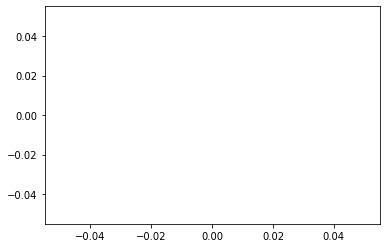

In [55]:
df_results = pd.concat(results)
df_results['r_alpha'] = df_results['r_alpha'].apply(lambda x: round(x, 4))
df_results['rmse'] = df_results['rmse'].apply(lambda x: round(x, 4))
#dataframe
df_results_plot = df_results[['n_features','rmse','r_alpha']].drop_duplicates()
#plot
_= sns.lineplot(x='n_features', y='rmse', data=df_results_plot)
_= plt.title("variation of the RMSE with respect with the number of features considered")

In [44]:
df_results_plot.sort_values(by='rmse').head(10)

,n_features,rmse,r_alpha
0,188,0.1299,0.000
0,27,0.1699,0.005
0,15,0.1809,0.010
0,9,0.1867,0.015
0,6,0.1914,0.020
0,6,0.1958,0.025
0,6,0.2008,0.030
0,5,0.2060,0.035
0,4,0.2096,0.040
0,4,0.2131,0.045


In [45]:
print("Take into account the average sale price in logarithmic scale {:.2f}.\nIn the original scale the mean is {:.2f} and the RMSE is {:.2f}".format(y_test.mean().values[0], np.exp(y_test.mean().values[0]), np.exp(0.1699)))

Take into account the average sale price in logarithmic scale 12.00.
In the original scale the mean is 162372.28 and the RMSE is 1.19


In [ ]:
# 162372 dollars and rmse error of 1.19 dollar  is quite low

## Extract the coefficients of the model that perform the best and has a low number of features

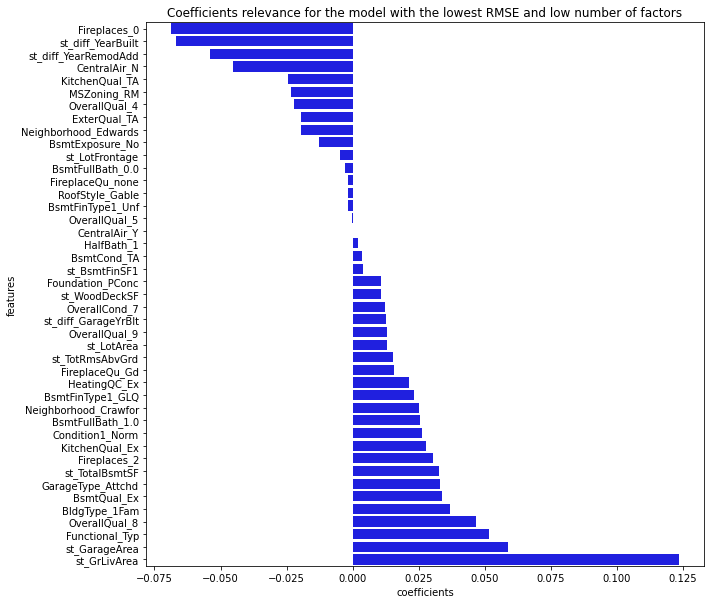

In [46]:
# Select the model with best compromise n_features vs rmse
df_results_best = df_results[(df_results['rmse']==0.1699) & (df_results['r_alpha']==0.005)]

# Format dataframe for plot
df_results_best['features'] = X_train.columns
df_results_best = df_results_best[df_results_best['coefficients']!=0]
df_results_best = df_results_best.sort_values(by='coefficients')

# _=plt.figure(figsize=(10,10))
# _=sns.barplot(x='coefficients', y='features', data=df_results_best, color='b')
# _=plt.title('Coefficients relevance for the model with the lowest RMSE and low number of factors')

## Find houses within the whole data frame that with this model predict the sale prices higher than the actual value.  Do they have something in common (within the selected features)?

In [ ]:
# use the alpha we found with the least features (alpha 0.005 and 27 variables)

In [47]:
# Initialize the Lasso linear regression model for the given parameter
lreg = Lasso(alpha=0.005)
  
# Train the model and test the performance
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)

In [48]:
# print y_pred
y_pred

array([11.84606552, 12.74201313, 11.60715109, 11.8951578 , 12.56019634,
       11.42754474, 12.23541031, 11.93788929, 11.38908823, 11.78101383,
       11.73639812, 11.69172458, 11.78940823, 12.20551876, 12.17173748,
       11.83648867, 12.2455523 , 11.83668094, 11.6117692 , 12.25305018,
       12.11886469, 12.23113442, 12.17941228, 11.78853462, 12.22381532,
       11.99781557, 12.12976209, 11.56675378, 12.1318891 , 12.17223715,
       11.69929856, 12.50838261, 12.29640496, 11.59480527, 12.50466882,
       11.90735505, 11.92023603, 12.2693117 , 12.67709792, 11.50457363,
       11.71589795, 12.4074304 , 11.65740843, 12.80289472, 11.74226164,
       11.74932061, 11.64993519, 11.77446696, 12.73979651, 11.77756755,
       11.62619308, 12.24481836, 11.7692985 , 12.62639321, 12.00431269,
       12.37682128, 12.22962394, 11.96056089, 11.9418971 , 11.70613653,
       11.27839428, 11.94569966, 12.65377965, 12.32894185, 12.55277261,
       12.29189121, 11.54308776, 12.69496326, 11.69185511, 11.99

In [49]:
#check if id in the index
X_test.head()

,st_LotFrontage,st_LotArea,st_MasVnrArea,st_BsmtFinSF1,st_BsmtUnfSF,st_TotalBsmtSF,st_1stFlrSF,st_2ndFlrSF,st_GrLivArea,st_TotRmsAbvGrd,...,st_EnclosedPorch_0,st_EnclosedPorch_1,st_3SsnPorch_0,st_3SsnPorch_1,st_ScreenPorch_0,st_ScreenPorch_1,st_PoolArea_0,st_PoolArea_1,st_MiscVal_0,st_MiscVal_1
Id,,,,,,,,,,,,,,,,,,,,,
893,0.032578,-0.222444,-0.572250,0.486749,-0.374458,0.017193,-0.233451,-0.785025,-0.855317,-0.287758,...,1,0,1,0,1,0,1,0,1,0
1106,1.346596,0.264770,1.454677,1.296799,-0.294825,0.933199,0.867761,1.832629,2.216046,1.624153,...,1,0,1,0,1,0,1,0,1,0
414,-0.624430,-0.153204,-0.572250,-0.968705,1.017984,-0.098442,-0.335415,-0.785025,-0.934374,-0.925062,...,1,0,1,0,1,0,1,0,1,0
523,-0.906006,-0.655383,-0.572250,-0.092798,0.101066,-0.107511,-0.396594,0.754772,0.322632,0.349546,...,1,0,1,0,1,0,1,0,1,0
1037,0.924233,0.346184,-0.180303,1.274846,0.085139,1.289172,1.173654,-0.785025,0.235669,-0.287758,...,1,0,1,0,1,0,1,0,1,0


In [50]:
#check if id in the index
y_test.head()

,log_SalePrice
Id,
893,11.947949
1106,12.691580
414,11.652687
523,11.976659
1037,12.661914


In [51]:
# we need to add a column 
y_test['prediction']=y_pred 
y_test

,log_SalePrice,prediction
Id,,
893,11.947949,11.846066
1106,12.691580,12.742013
414,11.652687,11.607151
523,11.976659,11.895158
1037,12.661914,12.560196
...,...,...
480,11.401670,11.780580
1362,12.468437,12.345736
803,12.149502,12.235209


In [52]:
#tranform to list from the dataframe: the x is the house id
xplot=y_test.index.tolist()

In [53]:
#transform to list both variables the real price and the prediction
realprice=y_test['log_SalePrice'].tolist()
prediction=y_test['prediction'].tolist()

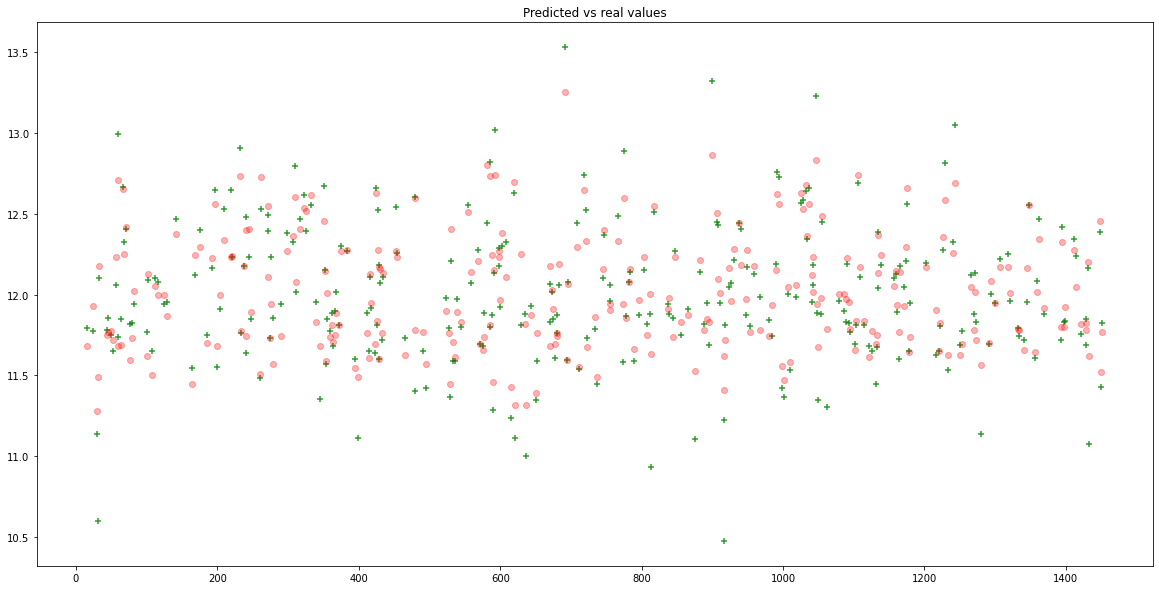

In [54]:
# Visualize accuracy of prediciton: the x is the index (house id)
_=plt.figure(figsize=(20,10))
_=plt.scatter(xplot, realprice, color='g', alpha=0.8, marker='+')
_=plt.scatter(xplot, prediction, color='r', alpha=0.3, marker='o')
_=plt.title("Predicted vs real values")